# Load [source_category, relation, target_category] triples from 34,000 sentences (all data in OzROCK)
## identify symantic relations

In [1]:
import pandas as pd
import numpy as np
import csv
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

import gensim
from gensim.models import word2vec;
from sklearn.cluster import KMeans;

from nltk.corpus import wordnet
#from nltk.corpus import verbnet
import spacy
# python -m spacy download en_core_web_lg
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

from nltk.stem import WordNetLemmatizer
wnl = WordNetLemmatizer()

FILE_TRIPLES = r'Files/OzROCK-master/All_dataset_triples.tsv'
df = pd.read_csv(FILE_TRIPLES,
                 delimiter="\t",
                 header=None,
                 quoting=csv.QUOTE_NONE,
                 encoding='latin1',
                 skip_blank_lines=True)
"""
FILE_TRIPLES = r'Files/OzROCK-master/All_dataset_triples_types_relations.tsv'
df = pd.read_csv(FILE_TRIPLES,
                 delimiter="\t",                 
                 quoting=csv.QUOTE_NONE,
                 encoding='latin1',
                 skip_blank_lines=True)
"""

df = df.replace(np.nan, '', regex=True)
print('df size = ', len(df))
print(df.head())

def update_dict(d, key):
    if key in d.keys():
        d[key] += 1
    else:
        d[key] = 1
    return d


def get_base_form(phrase):    
    resultwords  = [wnl.lemmatize(word, 'v') for word in phrase.split('_') if word.lower() not in stopwords]
    return '_'.join(resultwords)

def clean_relations_in_triples(input_triples):
    print('Num input triples = ', len(input_triples))
    triples = []
    relations_only = {}
    for s, rel_list, t in input_triples:
        #print('triples: ', s, rel_list, t)
        source = s.lower().replace(' ', '_')
        target = t.lower().replace(' ', '_')
        #print('- ', rel_list)
        relations = [r.lower().replace(' ', '_') for r in rel_list]
        #print('-- ', relations)
        relations = [r.replace('within', 'in') for r in relations]
        relations = [r.replace('is_parent_of', 'contains') for r in relations]
        relations = [r.replace('is_current_of', 'current_name_of') for r in relations]  
        relations = [r.replace('could_', '') for r in relations]
        relations = [r.replace('occurs_in', 'occur_in') for r in relations]
        relations = [r.replace('consists_of', 'consist_of') for r in relations]
        relations = [r.replace('hosted_by', 'hosted_in') for r in relations]
        relations = [r.replace('with_interbedded', 'interbedded_with') for r in relations]
        relations = [r.replace('may_', '') for r in relations]
        relations = [r.replace('can_', '') for r in relations]
        #print('-- ', relations)
        for r in relations:
            #print('---- ', r)
            if not r or r'(' in r or r')' in r or 'not' in r:
                triples.append([source, '', target])
                continue
            elif any(char.isdigit() for char in r):
                triples.append([source, '', target])
                continue
            elif '.' in r or '-' in r:
                triples.append([source, '', target])
                continue
            elif r in ['in', 'at', 'within', 'on']:
                triples.append([source, 'in', target]) # source, target, relation
                update_dict(relations_only, 'in')
                continue
            elif len(r) > 1 and len(r) < 25:
                #rel = get_base_form(r) # lemmas # 1165 relations
                triples.append([source, r, target]) # source, target, relation
                update_dict(relations_only, r)
            else:
                triples.append([source, '', target])
    print('[clean_relations_in_triples] Num Output Triples = ', len(triples)) # 3555-typed; 30,290 for all triples
    print('[clean_relations_in_triples] Num Relations = ', len(relations_only)) # 1348-typed, 1348 for all triples
    return triples, relations_only

df size =  65301
                0              1   2        3        4
0  felsic schists       granites         ROCK     ROCK
1      pyrrhotite  felsic schist  in  MINERAL     ROCK
2      pyrrhotite   chalcopyrite      MINERAL  MINERAL
3   felsic schist     pyrrhotite         ROCK  MINERAL
4    chalcopyrite  felsic schist  in  MINERAL     ROCK


In [32]:
triples_in_aFile = []
for i, line in df.iterrows():
    source = line[0].replace(' ', '_')
    target = line[1].replace(' ', '_')
    relations = line[2].split(',')
    triples_in_aFile.append([source, relations, target])

triples, relations_only = clean_relations_in_triples(triples_in_aFile)
print('Total number of triples = ', len(triples_in_aFile))
print(*triples[50:60], sep='\n')

Num input triples =  65301
[clean_relations_in_triples] Num Output Triples =  65412
[clean_relations_in_triples] Num Relations =  1331
Total number of triples =  65301
['wynangoo', '', 'calcrete']
['mount_magnet', 'of', 'perth']
['wondinong', 'lies_on', 'challa']
['challa', '', 'wondinong']
['uranium', 'in', 'yeelirrie']
['yeelirrie', 'in', 'western_australia']
['calcrete', 'developed_in', 'cainozoic']
['calcrete', '', 'windimurra_complex']
['cainozoic', '', 'calcrete']
['windimurra_igneous_complex', 'current_name_of', 'windimurra_complex']


In [3]:
# Words that appear only once or twice in a billion-word corpus are probably uninteresting typos and garbage.
# In addition, there’s not enough data to make any meaningful training on those words, so it’s best to ignore them
model = gensim.models.Word2Vec(sentences=triples, min_count=1, size=100, workers=4)
# min_count = 1 brings 25,341 unique words; 10 brings 5,614 unique words

print('Model vocabulary size = ', len(model.wv.vocab)) # 3267 for all triples; 1354 for grouped triples

Model vocabulary size =  3679


In [27]:
model['aged']
print([[s,r,t] for s,r,t in triples if r == 'aged'])

[['archaean', 'aged', 'greenstones'], ['archaean', 'aged', 'greenstones'], ['proterozoic', 'aged', 'fortescue_group'], ['proterozoic', 'aged', 'basalts'], ['proterozoic', 'aged', 'felsic_volcanics'], ['proterozoic', 'aged', 'sandstones'], ['proterozoic', 'aged', 'mudstones'], ['proterozoic', 'aged', 'cherts'], ['proterozoic', 'aged', 'banded_iron_formation'], ['proterozoic', 'aged', 'fortescue_group'], ['proterozoic', 'aged', 'basalts'], ['proterozoic', 'aged', 'felsic_volcanics'], ['proterozoic', 'aged', 'sandstones'], ['proterozoic', 'aged', 'mudstones'], ['proterozoic', 'aged', 'cherts'], ['proterozoic', 'aged', 'banded_iron_formation'], ['proterozoic', 'aged', 'warton_sandstone'], ['archaean', 'aged', 'greenstones'], ['archaean', 'aged', 'greenstones'], ['tertiary', 'aged', 'duricrust']]


/Users/majiga/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


In [28]:
print([[s,r,t] for s,r,t in triples if s in ['gold','coolgardie'] and t in ['gold','coolgardie']])

[['gold', '', 'coolgardie'], ['gold', 'distributed_through', 'coolgardie'], ['gold', 'in', 'coolgardie'], ['coolgardie', '', 'gold'], ['coolgardie', 'may', 'gold'], ['gold', 'in', 'coolgardie'], ['coolgardie', 'of', 'gold'], ['coolgardie', 'of', 'gold'], ['gold', '', 'coolgardie'], ['coolgardie', 'producing', 'gold'], ['coolgardie', 'in', 'gold'], ['gold', '', 'coolgardie'], ['gold', '', 'coolgardie'], ['coolgardie', '', 'gold'], ['gold', 'identified_by', 'coolgardie'], ['coolgardie', '', 'gold'], ['gold', 'in', 'coolgardie']]


In [24]:
FREQUENCY = 30

#print("Sorted relational words:\n", *sorted(verbs_adps.items(), key=lambda item: item[1], reverse = True), sep = '\n')
"""
stopwords = ['could', 'would', 'can', 'may', 'should', 'mn', 'au', 'sc', 'pelite', 'ca', 'cassiterite',
             'siltstone+', 'is', 'vein', 'ores', 'cement', 'galena', 'foliate', 'intrusives', 'layer', 'test',
             'serpentinised', 'scatter', 'flank', 'en', 'deposit', 'grain']
"""
ignore_relations = ['beneath', 'over', 'above', 'after', 'au', 'below', 'by', 'via', 'along', 'around',
                    'altered', 'assayed_for',
                    'to', 'into', 'of', 'basalt_with', 'with_quartz_veins', 'veins', 'galena_with', 'mn', 'sc', 'pelite',
                    'for', 'from', 'with', 'shear', 'between', 'throughout', 'may', 'ca_cassiterite', 'layered',
                    'ores', 'siltstone+', 'go', 'banded', 'known', 'intrusives', 'intermediate', 'foliated',
                    'situated_between', 'transported', 'grained', 'undifferentiated', 'weathering', 'recrystallised',
                    'serpentinised', 'sheared', 'trace', 'mineralised', 'cemented', 'interpreted',
                    'weathered', 'report', 'turns_off']

def update_dict_frequency(d, key, value):
    if key in d.keys():
        d[key] += value
    else:
        d[key] = value
    return d

print(len(relations_only))
relation_frequency_dict = {}
for item in sorted(relations_only.items(), key=lambda item: item[1]): # , reverse = True): # start from the highest frequency items
    if item[1] > FREQUENCY:
        if item[0] not in ignore_relations:
            update_dict_frequency(relation_frequency_dict, item[0], item[1])            
        #if item[0] not in ignore_relations:
        #    frequent_relations.append(item[0]) # 48
        #lemmas = get_base_form(item[0]) # get leammas
        #if get_base_form(item[0]): 
            #if lemmas not in ignore_relations:
            #    frequent_relations.append(lemmas) # 111 if FREQUENCY = 5; 43 if FREQUENCY = 10
            
print('Num frequent_relations = ', len(relation_frequency_dict)) # 1354
for k, v in sorted(relation_frequency_dict.items()):
    print(k, '\t', v) # 36-typed triples; 99 for all triples

1331
Num frequent_relations =  52
associated 	 99
associated_with 	 325
bearing 	 42
belonging_to 	 36
bounded_by 	 54
characterised_by 	 53
composed_of 	 56
comprise 	 35
comprised_of 	 86
comprises 	 122
comprising 	 126
consist_of 	 329
consisting_of 	 65
contain 	 67
containing 	 178
contains 	 3900
contaminated 	 57
covered_by 	 39
current_name_of 	 1763
derived_from 	 65
developed_in 	 60
divided_into 	 138
dominated_by 	 108
explored_for 	 55
hosted 	 123
hosted_in 	 164
hosts 	 78
in 	 3219
include 	 254
includes 	 80
including 	 313
interbedded 	 83
interbedded_with 	 71
intercalated 	 54
intercalated_with 	 59
interlayered 	 41
intrude 	 40
intruded 	 83
intruded_by 	 279
lies_in 	 35
located_in 	 61
occur_in 	 145
overlain_by 	 160
overlie 	 91
overlies 	 121
overlying 	 114
referred_to 	 32
represented_by 	 64
returned 	 35
situated_in 	 33
subdivided_into 	 64
surrounding 	 37


In [5]:
# Word synonym checking with VerbNet

def get_lemmas_spacy(phrase):
    doc = nlp(phrase)
    return '_'.join([token.lemma_ for token in doc])
    
def are_synonyms(verb1, verb2):    
    #print ("\t{0:20}{1:20}".format(verb1, lemmatizer.lemmatize(verb1)))
    lemma1 = get_lemmas_spacy(verb1)
    lemma2 = get_lemmas_spacy(verb2)
    #print('\t\tVerb1 lemma: ', lemma1)
    #print('\t\tVerb2 lemma: ', lemma2)
    synsets = wordnet.synsets(verb1, 'v')    
    for ss in synsets:
        #print('\t\tVerb1 synsets\' lemmas: ', ss.lemma_names())            
        if lemma2 in ss.lemma_names():
            return True
    return False

def update_dict_stringlist(d, k, v):
    if k in d.keys():
        d[k].append(v)
    else:
        d[k] = [v]
        
def print_dict(d):
    for k,v in d.items():
        print(k, v)

relation_synonyms = {}
skip_list = []

relation_sorted_byFrequency = [k for k, v in sorted(relation_frequency_dict.items(), key=lambda item: item[1], reverse = True)] # start from the highest frequency items
print('Sorted relations:\n', relation_sorted_byFrequency, '\n')

for i in range(0, len(relation_sorted_byFrequency)-1):
    w1 = relation_sorted_byFrequency[i]
    #print(i, '). Word1: ', i, '\t', w1)
    for j in range(1, len(relation_sorted_byFrequency)):
        w2 = relation_sorted_byFrequency[j]
        if w2 in skip_list:
            continue
        if are_synonyms(w1, w2) and w1 is not w2:
            update_dict_stringlist(relation_synonyms, w1, w2)
            skip_list.append(w2)
            #print('SYNONYMS: ', w1, w2)

print('\nNum synonym relations = ', len(relation_synonyms))
print_dict(relation_synonyms)
print('\nSkip_list = ', len(skip_list), skip_list)

Sorted relations:
 ['contains', 'in', 'current_name_of', 'consist_of', 'associated_with', 'including', 'intruded_by', 'include', 'containing', 'hosted_in', 'overlain_by', 'occur_in', 'divided_into', 'comprising', 'hosted', 'comprises', 'overlies', 'overlying', 'dominated_by', 'associated', 'overlie', 'comprised_of', 'intruded', 'interbedded', 'includes', 'hosts', 'interbedded_with', 'contain', 'consisting_of', 'derived_from', 'represented_by', 'subdivided_into', 'located_in', 'developed_in', 'intercalated_with', 'contaminated', 'composed_of', 'explored_for', 'bounded_by', 'intercalated', 'characterised_by', 'bearing', 'interlayered', 'intrude', 'covered_by', 'surrounding', 'belonging_to', 'lies_in', 'comprise', 'returned', 'situated_in', 'referred_to'] 


Num synonym relations =  9
contains ['containing', 'comprising', 'comprises', 'contain', 'bearing', 'comprise']
including ['include', 'includes']
include ['including']
hosted ['hosts']
overlies ['overlie']
overlying ['overlies']
intru

In [6]:
print(are_synonyms('consist', 'comprise'))
print(are_synonyms('contain', 'divide_into'))
print(are_synonyms('include', 'contain'))
wordnet.synsets('locate', 'v')  

True
False
False


[Synset('locate.v.01'),
 Synset('situate.v.01'),
 Synset('locate.v.03'),
 Synset('settle.v.04')]

In [7]:
synonyms_final = {'contains': ['contain', 'contains', 'containing', 'comprising', 'comprises',
                               'bearing', 'comprise', 'consist_of', 'consisting_of', 'comprised_of',
                               'composed_of', 'including', 'include', 'includes', 'subdivided_into',
                               'divided_into', 'surrounding'], #'surrounds', 'cover'
                  'hosts': ['hosted', 'hosts'],
                  #'separates': ['separating', 'separates'],
                  'overlies': ['overlies', 'overlie' ,'overlying'],
                  'intrude': ['intruded', 'intrude']}
skip_list = ['contain', 'containing', 'comprising', 'comprises', 'comprised_of',
             'bearing', 'comprise', 'consist_of', 'consisting_of', 'composed_of',
             'include', 'includes', 'including', 'hosted', #'separating',
             'overlie', 'overlying', 'intruded', 'subdivided_into', 'divided_into', 'surrounding'] # 'surrounds', 'cover'

In [8]:
relations_synonyms_joined = {}
for r, ss in synonyms_final.items():
    if (len(ss) > 1):
        f = 0
        for s in ss:
            print('synonym: ', r, s, relation_frequency_dict[s])
            f = f + relation_frequency_dict[s]
        relations_synonyms_joined[r] = f
    else:
        relations_synonyms_joined[r] = relation_frequency_dict[r]
        #print(r, relation_frequency_dict[r])

print('Num relation_frequency_dict = ', len(relation_frequency_dict))
print('Num relations_synonyms_joined = ', len(relations_synonyms_joined))
print_dict(relations_synonyms_joined)

relations_final = {}
print('\nCollecting final relations...')
for k,v in relation_frequency_dict.items():
    if k in skip_list:
        print('- skip: ', k)
        continue
    if k in relations_synonyms_joined.keys():
        #print('+ joined:', k)
        relations_final[k] = relations_synonyms_joined[k]    
    else:
        #print('+ single:', k)
        relations_final[k] = relation_frequency_dict[k]

print('\nNum frequent_relations = ', len(relation_frequency_dict)) # 1354
print('\nSkip_list = ', len(skip_list))
print('\nNum relations_final = ', len(relations_final))
print(*sorted(relations_final.keys()), sep='\n')

synonym:  contains contain 67
synonym:  contains contains 3900
synonym:  contains containing 178
synonym:  contains comprising 126
synonym:  contains comprises 122
synonym:  contains bearing 42
synonym:  contains comprise 35
synonym:  contains consist_of 329
synonym:  contains consisting_of 65
synonym:  contains comprised_of 86
synonym:  contains composed_of 56
synonym:  contains including 313
synonym:  contains include 254
synonym:  contains includes 80
synonym:  contains subdivided_into 64
synonym:  contains divided_into 138
synonym:  contains surrounding 37
synonym:  hosts hosted 123
synonym:  hosts hosts 78
synonym:  overlies overlies 121
synonym:  overlies overlie 91
synonym:  overlies overlying 114
synonym:  intrude intruded 83
synonym:  intrude intrude 40
Num relation_frequency_dict =  52
Num relations_synonyms_joined =  4
contains 5892
hosts 201
overlies 326
intrude 123

- skip:  comprise
- skip:  surrounding
- skip:  bearing
- skip:  composed_of
- skip:  subdivided_into
- skip

In [9]:
w_vectors = [] # positions in vector space
w_labels = [] # keep track of words to label our data again later
for word in relations_final.keys():
    try:
        w_vectors.append(model.wv[word])
        w_labels.append(word)
    except Exception as ex:
        print('Error: ', word, str(ex))
print('Num w_vectors = ', len(w_vectors))
print('Num w_labels = ', len(w_labels))

Num w_vectors =  32
Num w_labels =  32


In [10]:
NUM_CLUSTERS = 30

#### KMeans Clustering ###
from sklearn.metrics import pairwise_distances_argmin

def clustering_on_wordvecs(word_vectors, word_labels, num_clusters):
    # Initalize a k-means object and use it to extract centroids
    kmeans_clustering = KMeans(n_clusters = num_clusters, init='k-means++');
    y_kmeans = kmeans_clustering.fit_predict(word_vectors);
    return kmeans_clustering, y_kmeans

kmeans, preds = clustering_on_wordvecs(w_vectors, w_labels, NUM_CLUSTERS);
center_nodes = kmeans.cluster_centers_
#cluster_labels = kmeans.labels_
print('Clustering done.')

Clustering done.


[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 32 samples in 0.000s...
[t-SNE] Computed neighbors for 32 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 32 / 32
[t-SNE] Mean sigma: 0.499786
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.674431
[t-SNE] Error after 1300 iterations: 0.353496


/Users/majiga/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: Mean of empty slice.
  if sys.path[0] == '':
/Users/majiga/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


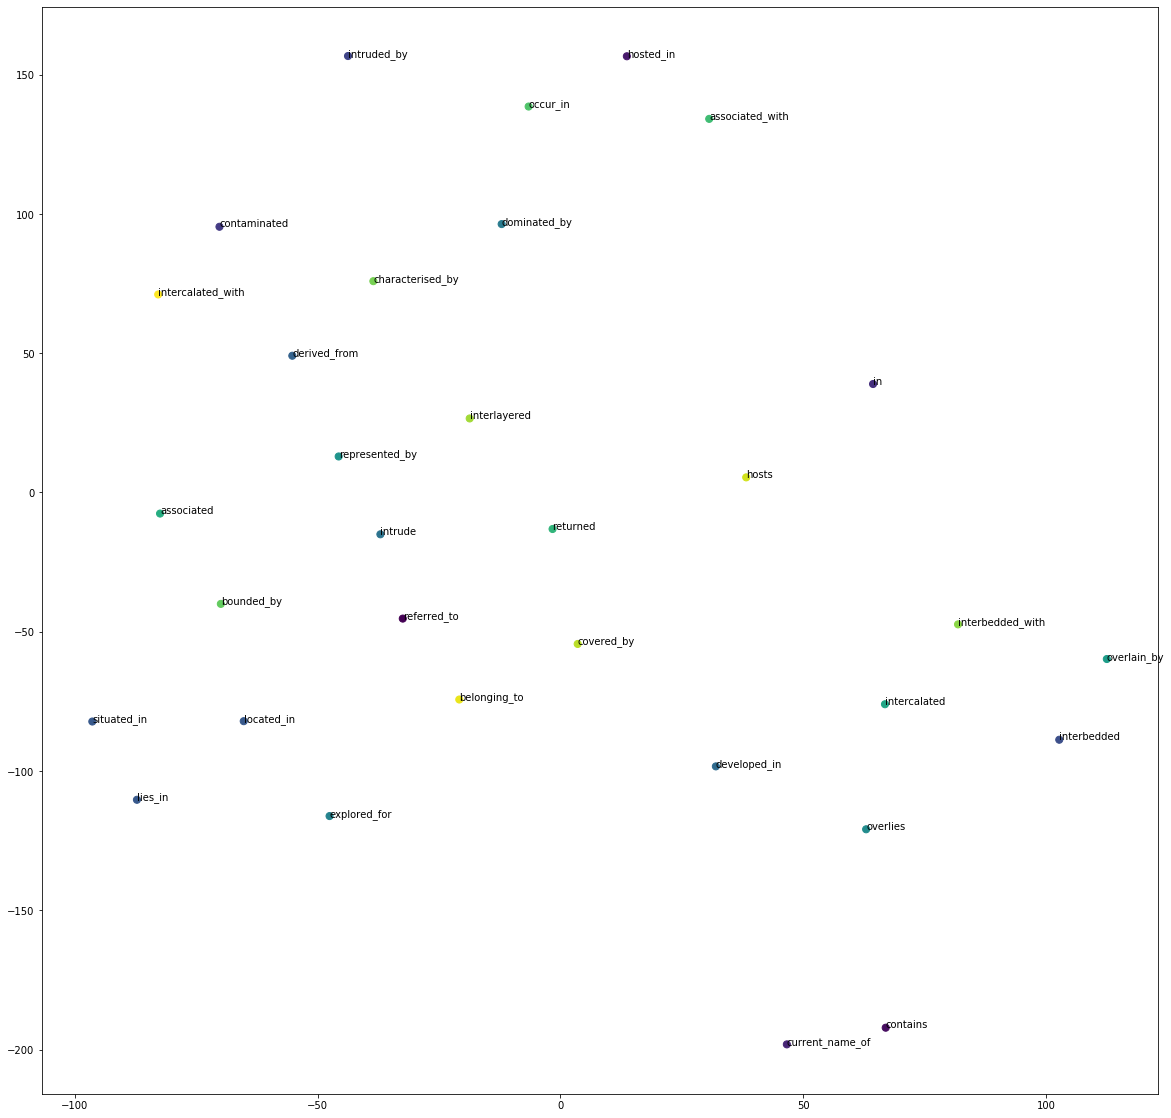

In [11]:
# Reduce using t-SNE and visualise
tsne = TSNE(n_components=2, verbose=1, perplexity=10, n_iter=3000)
tsne_result = tsne.fit_transform(w_vectors)

#pca = PCA(n_components=2)
#word_vectors = pca.fit_transform(w_vectors)

#plt.figure(figsize=(100,100))
plt.figure(figsize=(20,20))
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=preds, s=50, cmap='viridis')
    
centers = np.array([tsne_result[w_labels == i].mean(0) for i in range(NUM_CLUSTERS)]) # kmeans.cluster_centers_
#print(len(centers))
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);
    
for i, word in enumerate(w_labels):
    plt.annotate(word, xy=(tsne_result[i, 0], tsne_result[i, 1]))

#lbls = pairwise_distances_argmin(tsne_result, centers)
#for i, word in enumerate(lbls):
#    plt.annotate(word, xy=(centers[i, 0], centers[i, 1]))

plt.scatter(centers[:, 0], centers[:, 1], c='black', cmap='viridis');

plt.savefig('verbs_plot_clusters.png')
plt.show()

In [12]:
clusters = {}
for c, l in zip(preds, w_labels):
    if c in clusters:
        clusters[c].append(l)
    else:
        clusters[c] = [l]
print('***********\n1. KMeans Clustering:\n Num clusters = ', len(clusters), len(preds), len(w_labels))

def get_max(words4relations, d):
    max_w = ''
    max_f = 0
    for w in words4relations:
        if max_f < d[w]:
            max_f = d[w]
            max_w = w
    return max_w, max_f

for i in range(len(clusters)):
    # get the highest frequency item for the cluster name
    #print([unique_words[f] for f in clusters[i]])
    max_relation, max_freq = get_max(clusters[i], relation_frequency_dict)
    print('Cluster ID: ', i, ', Name: ', max_relation, [max_freq])
    #print('  Num items = ', len(clusters[i]))
    for w in clusters[i]:
        print(' - ', w, relation_frequency_dict[w])

***********
1. KMeans Clustering:
 Num clusters =  30 32 32
Cluster ID:  0 , Name:  referred_to [32]
 -  referred_to 32
Cluster ID:  1 , Name:  contains [3900]
 -  contains 3900
Cluster ID:  2 , Name:  hosted_in [164]
 -  hosted_in 164
Cluster ID:  3 , Name:  current_name_of [1763]
 -  current_name_of 1763
Cluster ID:  4 , Name:  in [3219]
 -  in 3219
Cluster ID:  5 , Name:  contaminated [57]
 -  contaminated 57
Cluster ID:  6 , Name:  intruded_by [279]
 -  intruded_by 279
Cluster ID:  7 , Name:  interbedded [83]
 -  interbedded 83
Cluster ID:  8 , Name:  located_in [61]
 -  situated_in 33
 -  lies_in 35
 -  located_in 61
Cluster ID:  9 , Name:  derived_from [65]
 -  derived_from 65
Cluster ID:  10 , Name:  developed_in [60]
 -  developed_in 60
Cluster ID:  11 , Name:  intrude [40]
 -  intrude 40
Cluster ID:  12 , Name:  dominated_by [108]
 -  dominated_by 108
Cluster ID:  13 , Name:  explored_for [55]
 -  explored_for 55
Cluster ID:  14 , Name:  overlies [121]
 -  overlies 121
Cluster

***********
2. Hierarchical Clustering:

32
31
20


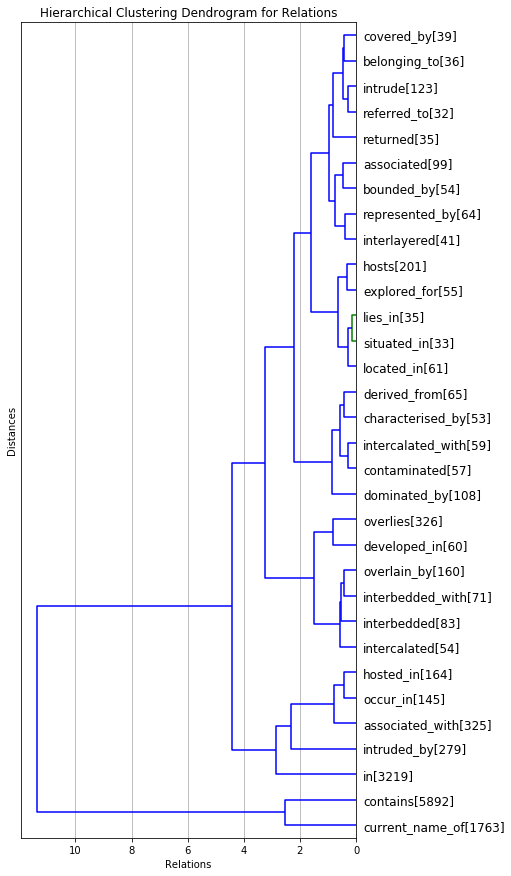

In [13]:
# import hierarchical clustering libraries
import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering

print('***********\n2. Hierarchical Clustering:\n')
      
# create dendrogram
plt.figure(figsize=(6, 15))  
plt.title("Hierarchical Clustering Dendrogram for Relations")  

lbls_freq = []
for w in w_labels:
    lbls_freq.append(w + '[' + str(relations_final[w]) + ']')

Z = shc.linkage(w_vectors, method='ward')
dend = shc.dendrogram(Z,
                      labels=lbls_freq,
                      orientation='left',#'right',
                      distance_sort='descending',
                      leaf_font_size=12,
                      color_threshold=0.25,
                      show_leaf_counts=True)

def get_number_of_clusters(height, Z):
    nbr_of_leaves = Z.shape[0] + 1
    merge_heights = Z[:, 2]
    nbr_of_clusters  = nbr_of_leaves - np.digitize(height, merge_heights)
    return nbr_of_clusters

print(get_number_of_clusters(0.1, Z)) # 43
print(get_number_of_clusters(0.2, Z)) # 28
print(get_number_of_clusters(0.5, Z)) # 13

plt.grid(axis='x');
plt.xlabel('Relations');
plt.ylabel('Distances');

plt.savefig('verbs_hierarchical_clustering.png', dpi=500)
plt.show()

In [14]:
# create clusters
# Agglomerative Hierarchical Clustering and 
# Divisive Hierarchical Clustering. We choose Euclidean distance and ward method for our algorithm class
print('***********\n3. Agglomerative Clustering:')

hc = AgglomerativeClustering(n_clusters=NUM_CLUSTERS, affinity = 'euclidean', linkage = 'ward')
y_hc=hc.fit_predict(w_vectors)
clustering = hc.labels_
print(len(clustering), len(w_labels),'\n')

agg_groups = {}
for c,w in zip(clustering, w_labels):
    update_dict_stringlist(agg_groups, c, w)

c = 1
writer = csv.writer(open("symantic_relations.csv", 'w'))
writer.writerow(['ID','ClusterName','Frequency','Relations'])
for cluster, rels in agg_groups.items():    
    max_word, max_value = get_max(rels, relations_final)
    #print('Cluster: ', cluster, max_word, max_value)
    #print(max_word, max_value)
    ws = []
    for w in rels:
        ws.append(w + ' ' + str(relations_final[w])) 
    row = [c, max_word, max_value] + (ws)
    writer.writerow(row)
    print(row)
    c += 1

***********
3. Agglomerative Clustering:
32 32 

[1, 'intrude', 123, 'referred_to 32', 'intrude 123']
[2, 'lies_in', 35, 'situated_in 33', 'lies_in 35']
[3, 'returned', 35, 'returned 35']
[4, 'belonging_to', 36, 'belonging_to 36']
[5, 'covered_by', 39, 'covered_by 39']
[6, 'interlayered', 41, 'interlayered 41']
[7, 'characterised_by', 53, 'characterised_by 53']
[8, 'bounded_by', 54, 'bounded_by 54']
[9, 'intercalated', 54, 'intercalated 54']
[10, 'explored_for', 55, 'explored_for 55']
[11, 'contaminated', 57, 'contaminated 57']
[12, 'intercalated_with', 59, 'intercalated_with 59']
[13, 'developed_in', 60, 'developed_in 60']
[14, 'located_in', 61, 'located_in 61']
[15, 'represented_by', 64, 'represented_by 64']
[16, 'derived_from', 65, 'derived_from 65']
[17, 'interbedded_with', 71, 'interbedded_with 71']
[18, 'hosts', 201, 'hosts 201']
[19, 'interbedded', 83, 'interbedded 83']
[20, 'associated', 99, 'associated 99']
[21, 'dominated_by', 108, 'dominated_by 108']
[22, 'overlies', 326, 'o

# Read a file and change relations into semantic relations

In [29]:
import networkx as nx
import simplejson as json

def save_graph(graph, fname):
    nodes = [{'id': n, 'group': graph.nodes[n]['group'], 'degree': str(graph.nodes[n]['degree'])} for n in graph.nodes()]
    links = [{'source': u, 'target': v, 'label': d['label']} for u, v, d in graph.edges(data=True)]
    with open(fname, 'w') as f:
        json.dump({'nodes': nodes, 'links': links}, f, indent=4,)            

def load_graph(filename):
    d = json.load(open(filename))
    g = nx.DiGraph()    
    for n in d['nodes']:
        if n['group'] != 'OTHER':
            g.add_node(n['id'], group = n['group'])
    for n in d['links']:
        g.add_edge(n['source'], n['target'], label = n['label'])
    return g

def reverse_direction(s, r, t):
    if r == 'overlies':
        return t, 'overlain_by', s
    if r == 'intrude':
        return t, 'intruded_by', s
    if r == 'hosts':
        return t, 'hosted_in', s
    if r == 'dominated':
        return t, 'dominated_by', s
    return s, r, t

# Read semantic relations saved in a file
semantic_relations_dict = {}
with open('Files/symantic_relations.csv', mode='r') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    next(csv_reader, None)
    for row in csv_reader:
        r_list = row[3:]
        rels = [r.strip().split(' ')[0].lower() for r in r_list if r]
        semantic_relations_dict[row[1]] = rels

print(semantic_relations_dict)

{'contains': ['contains', 'included', 'contain', 'containing', 'comprise', 'comprising', 'comprises', 'bearing', 'consist_of', 'consisting_of', 'comprised_of', 'composed_of', 'including', 'divided_into', 'include', 'includes', 'subdivided_into', 'surrounds', 'surrounding', 'cover'], 'in': ['in'], 'current_name_of': ['current_name_of'], 'overlies': ['overlies', 'overlie', 'overlying'], 'overlain_by': ['overlain_by', 'covered_by'], 'associated_with': ['associated_with', 'represented_by', 'associated', 'referred_to', 'recorded_from', 'recorded', 'explored_for', 'report', 'interpreted', 'identified', 'returned', 'assigned_to'], 'intrude': ['containing_scattered', 'intrude', 'interlayered', 'intrudes', 'intruded'], 'intruded_by': ['intruded_by'], 'hosts': ['hosts', 'hosted'], 'hosted_in': ['hosted_in'], 'occurs_in': ['occur_in', 'developed_in', 'detected_in', 'found_in', 'belonging_to'], 'dominated': ['dominated', 'characterised_by'], 'dominated_by': ['dominated_by', 'derived_from'], 'inter

In [30]:
## IRON ORE
from analyse import load_graph, resolve_plurals

FILENAME_iron_ore = r'Files/10_iron_ore_graphs/a075345_c125_2004_2007a_14419765.json'

graph = load_graph(FILENAME_iron_ore)
#print(nx.info(graph))
g = resolve_plurals(graph)

triples_iron_ore_file = []
for s, t, d in g.edges(data=True):
    triples_iron_ore_file.append([s, d['label'].split(','), t])
print('\nNum triples in a file = ', len(triples_iron_ore_file))

triples_iron_ore, relations_iron_ore = clean_relations_in_triples(triples_iron_ore_file)

semantic_triples_iron_ore = []    
for s,r,t in triples_iron_ore: # relations are single strings here
    found = False
    for k,v in semantic_relations_dict.items():
        if r in v:
            if [s, r, t] not in semantic_triples_iron_ore:
                semantic_triples_iron_ore.append([s, k, t])
                #print('+ ', s, r, t)
            found = True
            continue
    if not found:
        if [s, '', t] not in semantic_triples_iron_ore:
            semantic_triples_iron_ore.append([s, '', t])
        #print('- relation not found: ', s, r, t)
print('\nLen semantic_triples_iron_ore = ', len(semantic_triples_iron_ore))
#print(*semantic_triples_iron_ore, sep='\n')

pairs_relations = {}
def update_relations_for_pair(dct, s, r, t): # This takes relations into a list per [s t] pair
    key = s + '\t' + t
    if key in dct.keys():
        rels = dct[key]
        if r not in rels:
            dct[key].append(r)           
    else:
        dct[key] = [r]

for s, r, t in semantic_triples_iron_ore: # relations are single strings here too
    if r in ['overlies', 'intrude', 'hosts', 'dominated']:
        new_s, new_r, new_t = reverse_direction(s, r, t)
        update_relations_for_pair(pairs_relations, new_s, new_r, new_t)
    else:
        update_relations_for_pair(pairs_relations, s, r, t)
print('\nRelation pairs dictionary: ', len(pairs_relations))
#for k,v in pairs_relations.items():
#    print(k, v)

Semantic_G = nx.DiGraph() 
for k,v in pairs_relations.items():
    #print(k)
    s, t = k.split('\t')
    source = s.replace('_', ' ')
    target = t.replace('_', ' ')
    Semantic_G.add_node(source, group = g.nodes[source]['group'])
    Semantic_G.add_node(target, group = g.nodes[target]['group'])
    rels = [r for r in v if r]    
    if rels:
        Semantic_G.add_edge(source, target, label = ';'.join(rels))
    else:
        Semantic_G.add_edge(source, target, label = '')
print('\nSemantic graph: ', nx.info(Semantic_G))

degree_dict = dict(Semantic_G.degree(Semantic_G.nodes()))
nx.set_node_attributes(Semantic_G, degree_dict, 'degree')
save_graph(Semantic_G, r"Files/semantic_graph_iron_ore.json")

for s,t,r in Semantic_G.edges(data=True):
    if r['label']:
        print(s, '\t', r['label'], '\t', t)


Num triples in a file =  447
Num input triples =  447
[clean_relations_in_triples] Num Output Triples =  501
[clean_relations_in_triples] Num Relations =  76

Len semantic_triples_iron_ore =  471

Relation pairs dictionary:  446

Semantic graph:  Name: 
Type: DiGraph
Number of nodes: 110
Number of edges: 446
Average in degree:   4.0545
Average out degree:   4.0545
hamersley basin 	 in 	 pilbara region
western australia 	 contains 	 pilbara
western australia 	 in;contains 	 iron ore
western australia 	 in 	 perth
goethite 	 in 	 hematite
goethite 	 interbedded_with 	 shale
cloud break 	 located_in 	 pilbara region
cloud break 	 in 	 sulphur
iron ore 	 in 	 pilbara region
iron ore 	 in 	 australia
iron ore 	 in 	 microplaty hematite
iron ore 	 in 	 marra mamba iron formation
iron ore 	 in 	 perth
iron ore 	 in 	 pilbara
iron ore 	 in 	 hamersley province
iron ore 	 hosted_in 	 iron formation
australia 	 in 	 iron
microplaty hematite 	 in 	 marra mamba iron formation
microplaty hematite 

In [31]:
## GOLD DEPOSIT
from analyse import load_graph, resolve_plurals

FILENAME_gold_deposit = r'Files/10_gold_deposit_graphs/a074513_coolgardie_combined_annual_2006_final_13997651.json'

graph = load_graph(FILENAME_gold_deposit)
#print(nx.info(graph))
g = resolve_plurals(graph)

triples_iron_ore_file = []
for s, t, d in g.edges(data=True):
    triples_iron_ore_file.append([s, d['label'].split(','), t])
print('\nNum triples in a file = ', len(triples_iron_ore_file))

triples_iron_ore, relations_iron_ore = clean_relations_in_triples(triples_iron_ore_file)

semantic_triples_iron_ore = []    
for s,r,t in triples_iron_ore: # relations are single strings here
    found = False
    for k,v in semantic_relations_dict.items():
        if r in v:
            if [s, r, t] not in semantic_triples_iron_ore:
                semantic_triples_iron_ore.append([s, k, t])
                #print('+ ', s, r, t)
            found = True
            continue
    if not found:
        if [s, '', t] not in semantic_triples_iron_ore:
            semantic_triples_iron_ore.append([s, '', t])
        #print('- relation not found: ', s, r, t)
print('\nLen semantic_triples_iron_ore = ', len(semantic_triples_iron_ore))
#print(*semantic_triples_iron_ore, sep='\n')

pairs_relations = {}
def update_relations_for_pair(dct, s, r, t): # This takes relations into a list per [s t] pair
    key = s + '\t' + t
    if key in dct.keys():
        rels = dct[key]
        if r not in rels:
            dct[key].append(r)           
    else:
        dct[key] = [r]

for s, r, t in semantic_triples_iron_ore: # relations are single strings here too
    if r in ['overlies', 'intrude', 'hosts', 'dominated']:
        new_s, new_r, new_t = reverse_direction(s, r, t)
        update_relations_for_pair(pairs_relations, new_s, new_r, new_t)
    else:
        update_relations_for_pair(pairs_relations, s, r, t)
print('\nRelation pairs dictionary: ', len(pairs_relations))
#for k,v in pairs_relations.items():
#    print(k, v)

Semantic_G = nx.DiGraph() 
for k,v in pairs_relations.items():
    #print(k)
    s, t = k.split('\t')
    source = s.replace('_', ' ')
    target = t.replace('_', ' ')
    Semantic_G.add_node(source, group = g.nodes[source]['group'])
    Semantic_G.add_node(target, group = g.nodes[target]['group'])
    rels = [r for r in v if r]    
    if rels:
        Semantic_G.add_edge(source, target, label = ';'.join(rels))
    else:
        Semantic_G.add_edge(source, target, label = '')
print('\nSemantic graph: ', nx.info(Semantic_G))
degree_dict = dict(Semantic_G.degree(Semantic_G.nodes()))
nx.set_node_attributes(Semantic_G, degree_dict, 'degree')
save_graph(Semantic_G, r"Files/semantic_graph_gold_deposit.json")

for s,t,r in Semantic_G.edges(data=True):
    if r['label']:
        print(s, '\t', r['label'], '\t', t)


Num triples in a file =  780
Num input triples =  780
[clean_relations_in_triples] Num Output Triples =  852
[clean_relations_in_triples] Num Relations =  85

Len semantic_triples_iron_ore =  827

Relation pairs dictionary:  770

Semantic graph:  Name: 
Type: DiGraph
Number of nodes: 178
Number of edges: 770
Average in degree:   4.3258
Average out degree:   4.3258
western australia 	 in 	 gold
western australia 	 hosted_in 	 gabbro
western australia 	 hosted_in 	 amphibolite facies
archaean 	 in 	 coolgardie
archaean 	 in 	 western australia
archaean 	 in 	 amphibolite facies
archaean 	 dominated_by 	 breccia
archaean 	 in 	 lode gold deposit
gold 	 in 	 coolgardie
gold 	 in;occurs_in 	 dolerite
gold 	 in 	 perseverance
gold 	 in 	 big blow
gold 	 in;associated_with;occurs_in;hosted_in 	 sulphide
gold 	 in 	 diorite
gold 	 in;hosted_in 	 breccia
gold 	 in 	 granodiorite
gold 	 dominated_by 	 supergene
gold 	 associated_with 	 arsenopyrite
gold 	 associated_with;hosted_in 	 pyrrhotite
